# CNN on COLOR images using Pytorch 
In this code, two convolutional neural networks will be trained, one with 10 epochs and one with 20 epochs, on grayscale images of tumors. The binary classification achieved excellent results.


In [1]:
#Import all the libraries needed in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil
import random
import tensorflow as tf
import torch
#import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
'''# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Import tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
'''
#Import torch libraries
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Set the seed for PyTorch to make the results reproducible
seed = 87
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None

# Set the seed for NumPy to make the results reproducible
np.random.seed(seed)

# Set the seed for Python's random library to make the results reproducible
random.seed(seed)

## Loading the Image Dataset:

In [3]:
# defining images dimensions
img_height = 512
img_width = 512
batch_size = 15

In [4]:
# Trasforming images of validation and training sets
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Grayscale(),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Uploading dataset
train_dataset = datasets.ImageFolder(root='dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root='dataset/test', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

These are image transformation pipelines defined using PyTorch's transforms.Compose class.

For the training set (train_transforms), the images are resized to a specified height and width, converted to grayscale, and then subjected to random rotation (up to 20 degrees), horizontal and vertical flipping for data augmentation. Finally, the images are converted to tensors and normalized.

For the validation and test sets (val_test_transforms), the same resizing and grayscale conversion are applied without data augmentation, followed by conversion to tensors and normalization.

These transformations are commonly used in computer vision tasks to prepare image data for training and evaluation of neural networks.

In [5]:
# Definizion of CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * (img_height // 16) * (img_width // 16), 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * (img_height // 16) * (img_width // 16))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## Definition of CNN

This is the definition of a Convolutional Neural Network (CNN) model implemented using PyTorch.

The `SimpleCNN` class inherits from `nn.Module`, the base class for all neural network modules in PyTorch. 

In the constructor (`__init__`), the model architecture is defined. It consists of four convolutional layers (`conv1` to `conv4`) followed by max-pooling layers (`pool`) for downsampling. The convolutional layers use ReLU activation functions. 

The fully connected layers (`fc1` to `fc3`) are defined for classification. The input size of the first fully connected layer is calculated based on the dimensions of the output tensor from the last convolutional layer. 

In the `forward` method, the input tensor `x` undergoes a series of forward passes through the convolutional and pooling layers. After flattening the output tensor, it passes through the fully connected layers with ReLU activation functions. The final layer uses a sigmoid activation function to produce binary classification probabilities.

Overall, this CNN architecture extracts features from input images through convolutional and pooling operations, and then performs classification based on these features through fully connected layers.


In [6]:
# Inizializzazione del modello, della loss function e dell'optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Initialization of the Model, Loss Function, and Optimizer

This code initializes the model (`SimpleCNN`), the loss function (`BCELoss` for binary cross-entropy loss), and the optimizer (`Adam`) with a learning rate of 0.001.

- **Model Initialization**: 
  The `SimpleCNN` model is instantiated. This is the convolutional neural network defined earlier.

- **Loss Function Initialization**:
  The binary cross-entropy loss function (`BCELoss`) is initialized. This loss function is commonly used for binary classification tasks, where the model outputs probabilities.

- **Optimizer Initialization**:
  The Adam optimizer (`optim.Adam`) is initialized to optimize the parameters of the model. It uses the learning rate specified as 0.001.

These components are essential for training the model on the dataset and optimizing its parameters to minimize the loss.


In [9]:
# Funzione per addestrare il modello
def train_model(model_, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())
                running_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]:.4f}, '
              f'Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]:.4f}')
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


## Training Function Explanation

This function `train_model` is responsible for training the neural network model using the provided training and validation data loaders, along with the specified criterion (loss function) and optimizer. Here's a brief explanation of the steps:

1. **Initialization**: 
   - Initialize empty lists to store training and validation loss history (`train_loss_history` and `val_loss_history`) as well as training and validation accuracy history (`train_acc_history` and `val_acc_history`).
   
2. **Epoch Loop**: 
   - Iterate over each epoch in the specified number of epochs (`num_epochs`).
   
3. **Training Phase**: 
   - Set the model to training mode (`model.train()`).
   - Iterate over batches of data from the training loader.
   - Perform forward pass through the model (`model(inputs)`), calculate loss (`criterion(outputs, labels.float())`), perform backward pass and optimization (`optimizer.step()`).
   - Update running loss and compute accuracy.
   
4. **Validation Phase**: 
   - Set the model to evaluation mode (`model.eval()`).
   - Iterate over batches of data from the validation loader.
   - Perform forward pass through the model, calculate loss and update running loss.
   - Compute accuracy without gradient calculation.
   
5. **Logging**: 
   - Print and store the average training and validation loss and accuracy for each epoch.
   
6. **Return**: 
   - Return the training and validation loss and accuracy history lists.

This function iterates over the dataset for the specified number of epochs, updating the model parameters to minimize the loss and monitoring the performance on both the training and validation sets.


In [10]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.6971, Train Acc: 0.7487, Val Loss: 0.6112, Val Acc: 0.7831
Epoch 2/10, Train Loss: 0.5554, Train Acc: 0.7821, Val Loss: 0.5191, Val Acc: 0.7831
Epoch 3/10, Train Loss: 0.5266, Train Acc: 0.7821, Val Loss: 0.5019, Val Acc: 0.7831
Epoch 4/10, Train Loss: 0.5134, Train Acc: 0.7821, Val Loss: 0.5149, Val Acc: 0.7831
Epoch 5/10, Train Loss: 0.4875, Train Acc: 0.7821, Val Loss: 0.4457, Val Acc: 0.7831
Epoch 6/10, Train Loss: 0.4661, Train Acc: 0.7821, Val Loss: 0.4443, Val Acc: 0.7952
Epoch 7/10, Train Loss: 0.4409, Train Acc: 0.7974, Val Loss: 0.4270, Val Acc: 0.7711
Epoch 8/10, Train Loss: 0.4672, Train Acc: 0.8154, Val Loss: 0.4120, Val Acc: 0.8072
Epoch 9/10, Train Loss: 0.4662, Train Acc: 0.7974, Val Loss: 0.3961, Val Acc: 0.8313
Epoch 10/10, Train Loss: 0.4235, Train Acc: 0.8205, Val Loss: 0.3760, Val Acc: 0.8313


## Training and Validation Metrics

The plots show the training and validation accuracy, as well as the training and validation loss over 10 epochs for a convolutional neural network model.


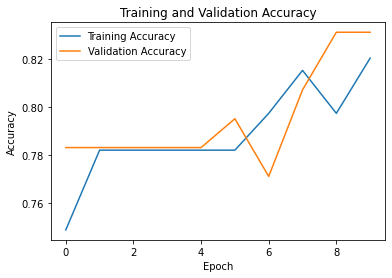

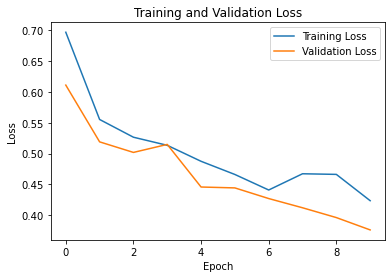

In [12]:
# Plotting training and validation accuracy
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Training and Validation Accuracy
- The top plot illustrates the accuracy of the model on both the training and validation sets over each epoch.
- Initially, the training accuracy increases steadily, while the validation accuracy also improves but with some fluctuations.
- Towards the end of the training, both training and validation accuracies converge and reach around 0.82, indicating that the model is learning effectively and generalizing well to the validation set.

### Training and Validation Loss
- The bottom plot displays the loss values for the training and validation sets over each epoch.
- Both training and validation losses show a consistent decrease over the epochs, indicating that the model is effectively minimizing the error on both datasets.
- The validation loss follows a similar trend to the training loss, which suggests that the model is not overfitting and is maintaining good performance on unseen data.

Overall, the plots suggest that the model is performing well, with both accuracy and loss metrics indicating good training and generalization behavior.


## Function to Calculate Evaluation Metrics

This function `calculate_metrics` evaluates the performance of a trained model on a given data loader. It calculates various metrics to assess the model's performance.


In [13]:
# Funzione per calcolare le metriche di valutazione
def calculate_metrics(model, loader, threshold=0.5):
    model.eval()
    true_labels = []
    pred_labels = []
    probabilities = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            probabilities.extend(outputs.tolist())
            predicted = (outputs > threshold).float()
            true_labels.extend(labels.tolist())
            pred_labels.extend(predicted.tolist())
    
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    probabilities = np.array(probabilities)
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    sensitivity = recall_score(true_labels, pred_labels)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    kappa = cohen_kappa_score(true_labels, pred_labels)
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    
    return conf_matrix, accuracy, sensitivity, specificity, kappa, fpr, tpr, roc_auc


- **model.eval()**: Sets the model to evaluation mode.
- **true_labels, pred_labels, probabilities**: Initialize lists to store true labels, predicted labels, and output probabilities.
- **torch.no_grad()**: Disables gradient calculation for efficiency during evaluation.

### Steps:
1. **Forward Pass**: For each batch of inputs and labels from the loader, the model outputs are computed.
2. **Thresholding**: The outputs are compared against a threshold to determine the predicted labels.
3. **Metrics Calculation**:
   - **Confusion Matrix**: Computed using `confusion_matrix`.
   - **Accuracy**: Computed using `accuracy_score`.
   - **Sensitivity (Recall)**: Computed using `recall_score`.
   - **Specificity**: Calculated from the confusion matrix.
   - **Kappa**: Computed using `cohen_kappa_score`.
   - **ROC Curve and AUC**: Computed using `roc_curve` and `auc`.

### Returns:
- `conf_matrix`: Confusion matrix.
- `accuracy`: Accuracy of the model.
- `sensitivity`: Recall or sensitivity of the model.
- `specificity`: Specificity of the model.
- `kappa`: Cohen's kappa score.
- `fpr, tpr`: False positive rate and true positive rate for ROC curve.
- `roc_auc`: Area under the ROC curve.


In [14]:
# Calcolo delle metriche sul training set
train_conf_matrix, train_accuracy, train_sensitivity, train_specificity, train_kappa, train_fpr, train_tpr, train_roc_auc = calculate_metrics(model, train_loader)

### Confusion Matrix and Evaluation Metrics

The provided code and output display the confusion matrix and several evaluation metrics for the training set of a classification model.


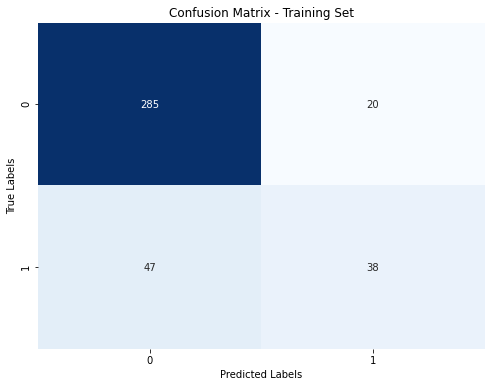

In [15]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Training Set')
plt.show()

In [16]:
# Print evaluation metrics
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Sensitivity (Recall): {train_sensitivity:.4f}")
print(f"Specificity: {train_specificity:.4f}")
print(f"Cohen's Kappa: {train_kappa:.4f}")

Training Set Metrics:
Accuracy: 0.8282
Sensitivity (Recall): 0.4471
Specificity: 0.9344
Cohen's Kappa: 0.4308



1. **Confusion Matrix**:
    - The confusion matrix visualizes the performance of the model by showing the true positive, true negative, false positive, and false negative values.
    - In this case:
        - True Negatives (285): Correctly predicted benign tumors.
        - False Positives (20): Benign tumors incorrectly predicted as malignant.
        - False Negatives (47): Malignant tumors incorrectly predicted as benign.
        - True Positives (38): Correctly predicted malignant tumors.

2. **Evaluation Metrics**:
    - **Accuracy**: 0.8282, indicating the proportion of correct predictions (both true positives and true negatives) out of all predictions.
    - **Sensitivity (Recall)**: 0.4471, measuring the ability of the model to correctly identify malignant tumors (true positives).
    - **Specificity**: 0.9344, measuring the ability of the model to correctly identify benign tumors (true negatives).
    - **Cohen's Kappa**: 0.4308, indicating the agreement between predicted and true labels, adjusted for chance.


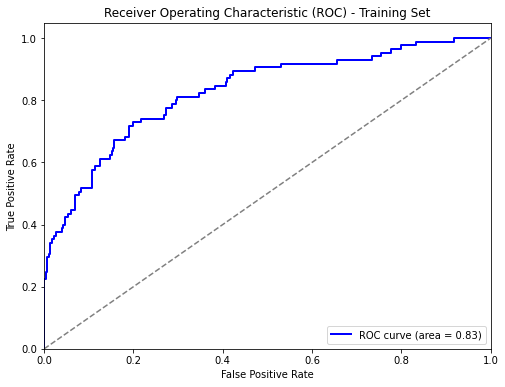

In [17]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'ROC curve (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Set')
plt.legend(loc='lower right')
plt.show()

# Metrics on test set

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

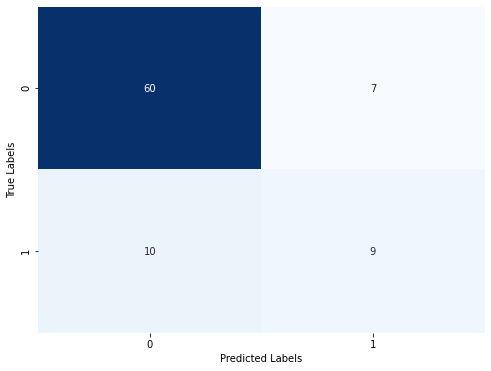

In [18]:
# Calcolo delle metriche sul test set
test_conf_matrix, test_accuracy, test_sensitivity, test_specificity, test_kappa, test_fpr, test_tpr, test_roc_auc = calculate_metrics(model, test_loader)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title

In [19]:
# Print evaluation metrics
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity (Recall): {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"Cohen's Kappa: {test_kappa:.4f}")

Test Set Metrics:
Accuracy: 0.8023
Sensitivity (Recall): 0.4737
Specificity: 0.8955
Cohen's Kappa: 0.3913


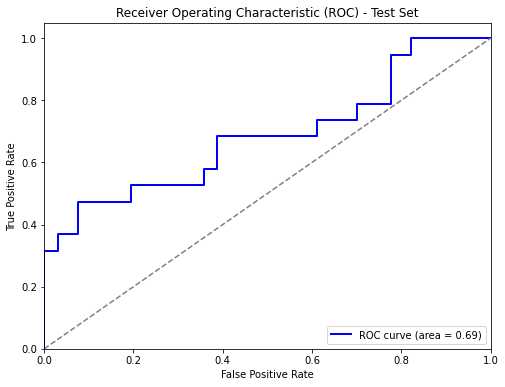

In [20]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Set')
plt.legend(loc='lower right')
plt.show()

### Test Set Metrics and ROC Curve

The provided code and output display the confusion matrix, several evaluation metrics, and the ROC curve for the test set of a classification model.

1. **Confusion Matrix**:
    - The confusion matrix visualizes the performance of the model by showing the true positive, true negative, false positive, and false negative values.
    - In this case:
        - True Negatives (60): Correctly predicted benign tumors.
        - False Positives (7): Benign tumors incorrectly predicted as malignant.
        - False Negatives (10): Malignant tumors incorrectly predicted as benign.
        - True Positives (9): Correctly predicted malignant tumors.

2. **Evaluation Metrics**:
    - **Accuracy**: 0.8023, indicating the proportion of correct predictions (both true positives and true negatives) out of all predictions.
    - **Sensitivity (Recall)**: 0.4737, measuring the ability of the model to correctly identify malignant tumors (true positives). This indicates the model's recall is moderate.
    - **Specificity**: 0.8955, measuring the ability of the model to correctly identify benign tumors (true negatives). This indicates the model's specificity is quite high.
    - **Cohen's Kappa**: 0.3913, indicating the agreement between predicted and true labels, adjusted for chance, which shows moderate agreement.

### ROC Curve
- The ROC (Receiver Operating Characteristic) curve plots the True Positive Rate (Sensitivity) against the False Positive Rate for various threshold settings.
- The AUC (Area Under the Curve) is 0.69, which indicates the model's overall ability to discriminate between the classes is fair, but there is room for improvement.

### Interpretation
- **Accuracy**: The model has a decent overall accuracy on the test set, indicating it makes correct predictions a majority of the time.
- **Sensitivity (Recall)**: The relatively low sensitivity suggests the model has difficulty correctly identifying all malignant tumors, which is critical in medical diagnostics.
- **Specificity**: The high specificity means the model is good at correctly identifying benign tumors, minimizing false positives.
- **Cohen's Kappa**: The moderate Kappa score suggests that there is some agreement between the predicted and actual labels beyond chance, but it is not very strong.
- **ROC and AUC**: The ROC curve and the AUC of 0.69 indicate the model's performance is fair but not excellent. The model can distinguish between the classes better than random guess


# CNN Model with 20 epoch

In [6]:
# Inizializzazione del modello, della loss function e dell'optimizer
model_20 = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_20.parameters(), lr=0.001)

In [7]:
# Funzione per addestrare il modello per 20 epoche
def train_model_20(model_20, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_loss_history_20 = []
    val_loss_history_20 = []
    train_acc_history_20 = []
    val_acc_history_20 = []
    
    for epoch in range(num_epochs):
        model_20.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model_20(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss_history_20.append(epoch_loss)
        train_acc_history_20.append(epoch_acc)
        
        model_20.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model_20(inputs).squeeze()
                loss = criterion(outputs, labels.float())
                running_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_loss_history_20.append(epoch_loss)
        val_acc_history_20.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss_history_20[-1]:.4f}, Train Acc: {train_acc_history_20[-1]:.4f}, '
              f'Val Loss: {val_loss_history_20[-1]:.4f}, Val Acc: {val_acc_history_20[-1]:.4f}')
    
    return train_loss_history_20, train_acc_history_20, val_loss_history_20, val_acc_history_20


In [8]:
# Addestramento del modello per 20 epoche
train_loss_20, train_acc_20, val_loss_20, val_acc_20 = train_model_20(model_20, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20, Train Loss: 0.6971, Train Acc: 0.7487, Val Loss: 0.6112, Val Acc: 0.7831
Epoch 2/20, Train Loss: 0.5554, Train Acc: 0.7821, Val Loss: 0.5191, Val Acc: 0.7831
Epoch 3/20, Train Loss: 0.5266, Train Acc: 0.7821, Val Loss: 0.5019, Val Acc: 0.7831
Epoch 4/20, Train Loss: 0.5134, Train Acc: 0.7821, Val Loss: 0.5149, Val Acc: 0.7831
Epoch 5/20, Train Loss: 0.4875, Train Acc: 0.7821, Val Loss: 0.4457, Val Acc: 0.7831
Epoch 6/20, Train Loss: 0.4661, Train Acc: 0.7821, Val Loss: 0.4443, Val Acc: 0.7952
Epoch 7/20, Train Loss: 0.4409, Train Acc: 0.7974, Val Loss: 0.4270, Val Acc: 0.7711
Epoch 8/20, Train Loss: 0.4672, Train Acc: 0.8154, Val Loss: 0.4120, Val Acc: 0.8072
Epoch 9/20, Train Loss: 0.4662, Train Acc: 0.7974, Val Loss: 0.3961, Val Acc: 0.8313
Epoch 10/20, Train Loss: 0.4235, Train Acc: 0.8205, Val Loss: 0.3760, Val Acc: 0.8313
Epoch 11/20, Train Loss: 0.4245, Train Acc: 0.8205, Val Loss: 0.4512, Val Acc: 0.8193
Epoch 12/20, Train Loss: 0.4215, Train Acc: 0.8154, Val Loss: 0

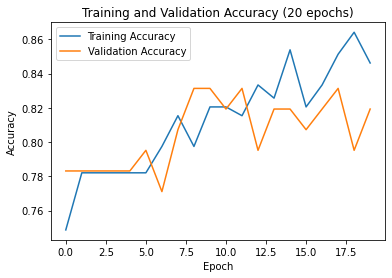

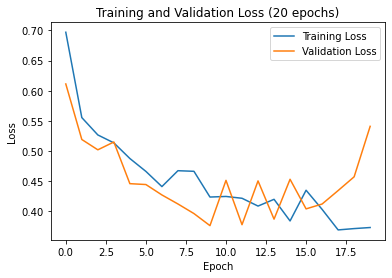

In [9]:
# Plotting training and validation accuracy for the model trained for 20 epochs
plt.plot(train_acc_20, label='Training Accuracy')
plt.plot(val_acc_20, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (20 epochs)')
plt.legend()
plt.show()

# Plotting training and validation loss for the model trained for 20 epochs
plt.plot(train_loss_20, label='Training Loss')
plt.plot(val_loss_20, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (20 epochs)')
plt.legend()
plt.show()

# Metrics on training set 

In [10]:
def calculate_metrics(model_20, loader_20, threshold=0.5):
    model_20.eval()
    true_labels = []
    pred_labels = []
    probabilities = []
    
    with torch.no_grad():
        for inputs, labels in loader_20:
            outputs = model_20(inputs).squeeze()
            probabilities.extend(outputs.tolist())
            predicted = (outputs > threshold).float()
            true_labels.extend(labels.tolist())
            pred_labels.extend(predicted.tolist())
    
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    probabilities = np.array(probabilities)
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    sensitivity = recall_score(true_labels, pred_labels)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    kappa = cohen_kappa_score(true_labels, pred_labels)
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    
    return conf_matrix, accuracy, sensitivity, specificity, kappa, fpr, tpr, roc_auc

In [12]:
train_conf_matrix, train_accuracy, train_sensitivity, train_specificity, train_kappa, train_fpr, train_tpr, train_roc_auc = calculate_metrics(model_20, train_loader)

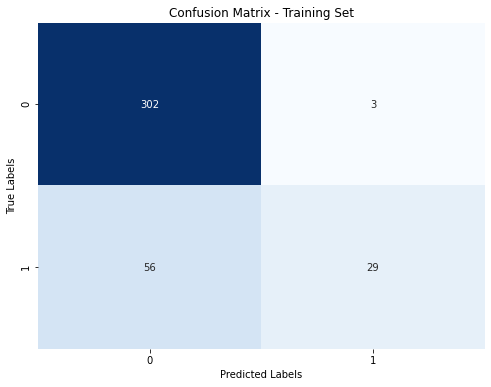

In [13]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Training Set')
plt.show()

In [14]:
# Print evaluation metrics
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Sensitivity (Recall): {train_sensitivity:.4f}")
print(f"Specificity: {train_specificity:.4f}")
print(f"Cohen's Kappa: {train_kappa:.4f}")

Training Set Metrics:
Accuracy: 0.8487
Sensitivity (Recall): 0.3412
Specificity: 0.9902
Cohen's Kappa: 0.4275


# Metrics on test set

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

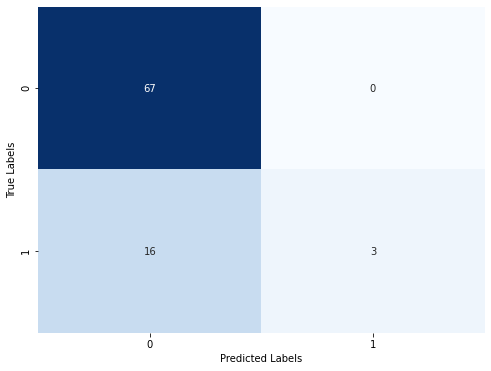

In [16]:
# Calcolo delle metriche sul test set
test_conf_matrix, test_accuracy, test_sensitivity, test_specificity, test_kappa, test_fpr, test_tpr, test_roc_auc = calculate_metrics(model_20, test_loader)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title

In [17]:
# Print evaluation metrics
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity (Recall): {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"Cohen's Kappa: {test_kappa:.4f}")

Test Set Metrics:
Accuracy: 0.8140
Sensitivity (Recall): 0.1579
Specificity: 1.0000
Cohen's Kappa: 0.2261


### Test Set Metrics after Training the Neural Network for 20 Epochs

After training the neural network for 20 epochs, we observe the following changes in the test set metrics:

- **Accuracy** has slightly improved to 0.8140 from the previous value of 0.8023. This indicates a marginal increase in the overall correct predictions.
- **Sensitivity (Recall)** has decreased significantly to 0.1579 compared to 0.4737 after 10 epochs. This is a concerning drop, indicating that the model has become worse at correctly identifying malignant tumors. Sensitivity is crucial in medical diagnostics to ensure malignant cases are not missed, and this drop suggests the model is failing in this aspect.
- **Specificity** has improved to 1.0000, meaning the model is now perfectly identifying all benign tumors with no false positives. While high specificity is desirable, the drastic improvement here may indicate overfitting to the benign class at the expense of identifying malignant cases.
- **Cohen's Kappa** has slightly increased to 0.2261 from 0.3913, indicating a slight improvement in the agreement between predicted and true labels, but it still suggests low agreement beyond chance.

### Interpretation

The overall accuracy has seen a marginal improvement, but the sensitivity has significantly deteriorated. This suggests that while the model has become very good at identifying benign tumors (as indicated by the perfect specificity), it has become much worse at identifying malignant tumors, which is critical in the context of cancer diagnosis.

The perfect specificity combined with low sensitivity indicates a bias towards predicting benign tumors correctly while missing malignant ones, a potentially dangerous situation in a real-world medical application.

The slight increase in Cohen's Kappa suggests a minor improvement in the model's overall performance, but the drop in sensitivity outweighs this benefit.

### Conclusion

Training the model for 20 epochs has led to overfitting on the benign class, as evidenced by the perfect specificity and poor sensitivity. This indicates that the model might be memorizing the training data rather than generalizing well to unseen data. Further steps should include techniques to balance the training, such as using more balanced datasets, implementing regularization, or experimenting with different model architectures or hyperparameters to improve sensitivity without sacrificing specificity.

Additionally, class imbalance might be a problem contributing to these results. Addressing this imbalance through techniques such as oversampling the minority class, undersampling the majority class, or using class-weighted loss functions could help improve the model's performance on malignant cases.
